In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import pickle
import seaborn as sns

In [2]:
model = xgb.XGBClassifier()
model.load_model('xgboost_abgabe.json')


In [3]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=20,
              missing=-999, monotone_constraints='()', n_estimators=13,
              n_jobs=0, nthread=4, num_parallel_tree=1,
              objective='binary:hinge', predictor='auto', random_state=0, ...)>

**Feature Importances**

Weight: Occurance of feature over all trees

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

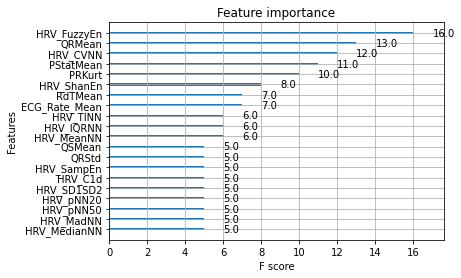

In [4]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')

Gain: Average gain of splits which use the feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

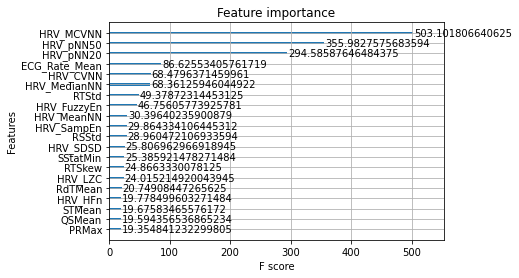

In [5]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

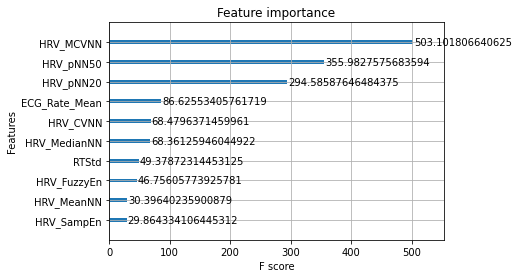

In [6]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')

Total gain: accumulated gain of feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

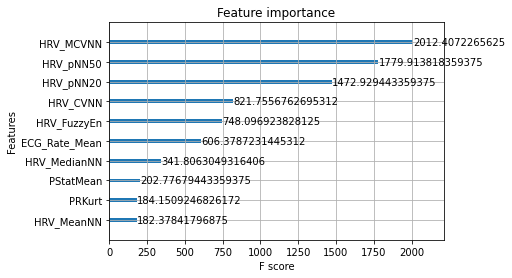

In [7]:
xgb.plot_importance(model, max_num_features=10, importance_type='total_gain')

Cover: average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

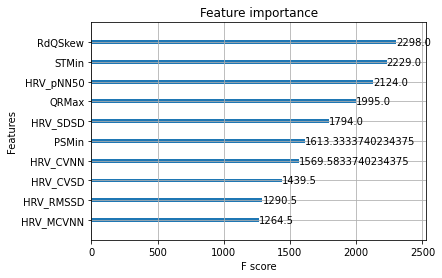

In [8]:
xgb.plot_importance(model, max_num_features=10, importance_type='cover')

Top 50 Features sorted by gain

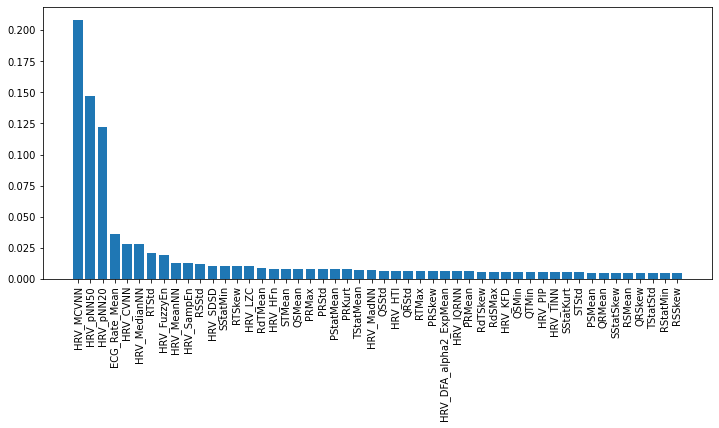

In [18]:
features = model.feature_importances_
featnames = model.feature_names_in_
sortednames = [x for _, x in sorted(zip(features, featnames))]
sortedfeat = sorted(features)
sortedfeat.reverse()
sortednames.reverse()

plt.figure(figsize=(12,5))
plt.bar(sortednames[0:50], sortedfeat[0:50])
plt.xticks(rotation='vertical')
plt.show()

**Combined Feature Ranking of weight and gain**

Top 20 Features sorted by gain with weight and gain

96


<AxesSubplot:>

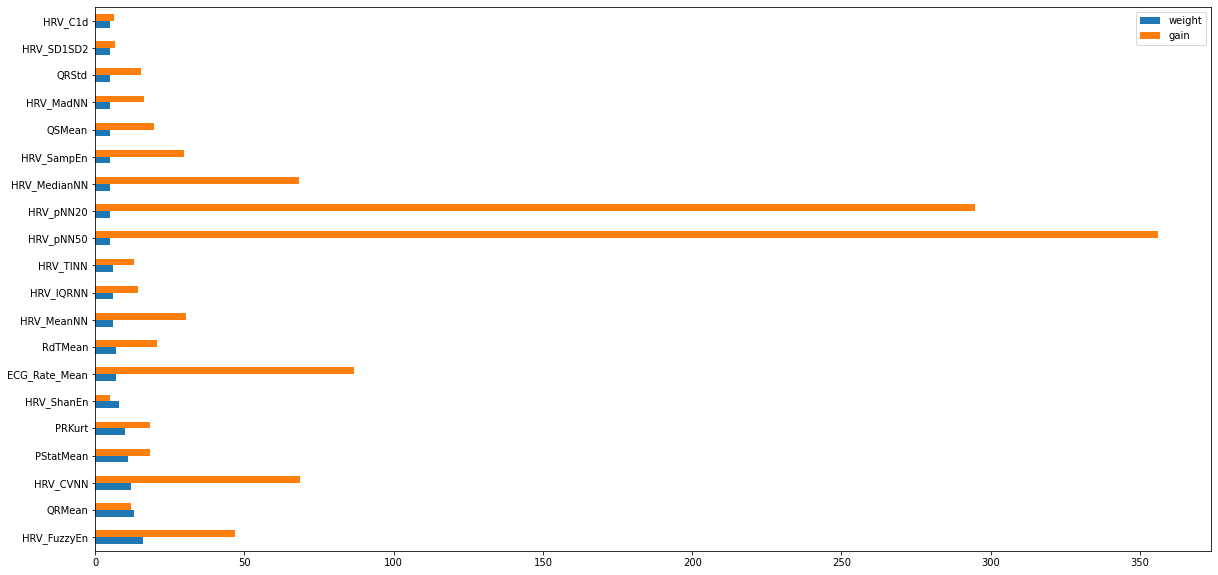

In [10]:
feature_important_w = model.get_booster().get_score(importance_type='weight')
feature_important_g = model.get_booster().get_score(importance_type='gain')

keys_W = list(feature_important_w.keys())
values_W = list(feature_important_w.values())
print(len(keys_W))

keys_G = list(feature_important_g.keys())
values_G = list(feature_important_g.values())

data = pd.DataFrame(data={'weight':values_W, 'gain':values_G}, index=keys_W).sort_values(by = "gain", ascending=False)
data.nlargest(20, columns=["weight","gain"]).plot(kind='barh', figsize = (20,10)) ## plot top 40 features

Custom ranking: features sorted by combining their rank in gain an weight metric

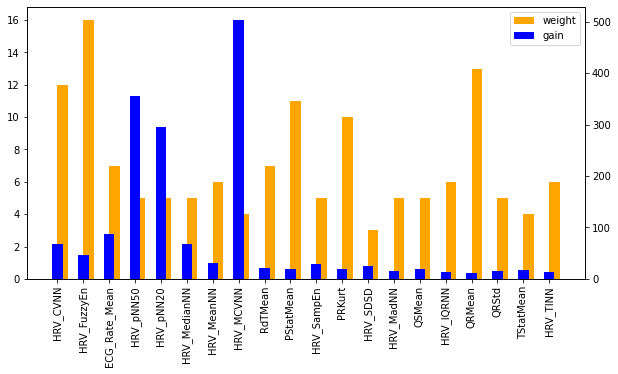

In [11]:
sorted_dict_w = dict(sorted(feature_important_w.items(), key=lambda item: item[1], reverse=True))
sorted_dict_g = dict(sorted(feature_important_g.items(), key=lambda item: item[1], reverse=True))
sorted_dict_w_rank = {}
sorted_dict_w_rank = {}
i  = len(sorted_dict_w)
for key in sorted_dict_w:
    sorted_dict_w[key] = i
    i = i -1
i  = len(sorted_dict_w)
for key in sorted_dict_g:
    sorted_dict_g[key] = i
    i = i -1   

combined_rank = {}
for key in sorted_dict_g:
    combined_rank[key] = (sorted_dict_g[key]+sorted_dict_w[key])/2
combined_rank = dict(sorted(combined_rank.items(), key=lambda item: item[1], reverse=True))

gain = []
weight = []
names = []
for key in combined_rank:
    gain.append(feature_important_g[key])
    weight.append(feature_important_w[key])
    names.append(key)

lim=20
fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation='vertical')
ax2=ax.twinx()
p1 = ax.bar(names[0:lim], weight[0:lim], label='weight',color='orange',align='edge', width=0.4)
p2 = ax2.bar(names[0:lim], gain[0:lim], label='gain', color='blue', width=0.4)
plt.legend(handles=[p1,p2])
plt.show()

Custom ranking: features sorted by multipling gain and weight

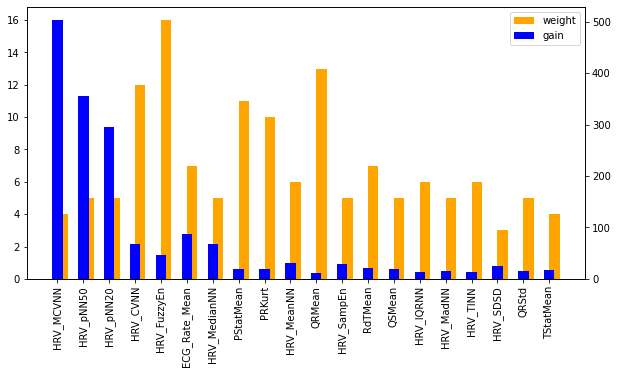

In [12]:
commbinded_feature_importance = {}
for key in feature_important_g:
    commbinded_feature_importance[key]=feature_important_g[key]*feature_important_w[key]

sorted_dict = dict(sorted(commbinded_feature_importance.items(), key=lambda item: item[1], reverse=True))

gain = []
weight = []
combined = []
names = []
for key in sorted_dict:
    gain.append(feature_important_g[key])
    weight.append(feature_important_w[key])
    combined.append(sorted_dict)
    names.append(key)

lim=20
fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation='vertical')
ax2=ax.twinx()
p1 = ax.bar(names[0:lim], weight[0:lim], label='weight',color='orange',align='edge', width=0.4)
p2 = ax2.bar(names[0:lim], gain[0:lim], label='gain', color='blue', width=0.4)
plt.legend(handles=[p1,p2])
plt.show()

**Top Feature correlations to Type (Normal or Afib)**

In [13]:
with open('Neurokit_Dataset.pkl', 'rb') as mit:
    dat = pickle.load(mit)

featkeys= list(keys_W)[0:15]
featkeys.append('TYPE')
dat['TYPE'].replace('A', 1, inplace=True)
dat['TYPE'].replace('N', 0, inplace=True)
print
dat2 = dat[featkeys]

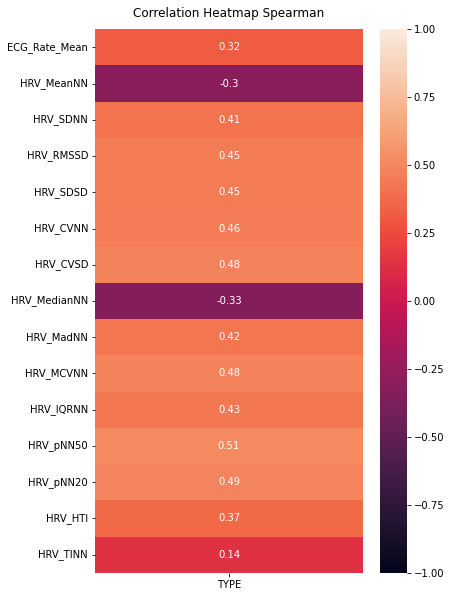

In [14]:
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(dat2.corr(method='spearman')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Spearman', fontdict={'fontsize':12}, pad=12);

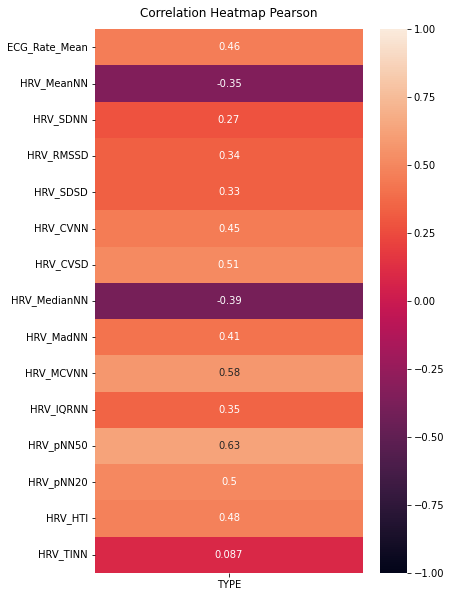

In [15]:
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(dat2.corr(method='pearson')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Pearson', fontdict={'fontsize':12}, pad=12);

In [16]:
#sns.pairplot(dat2.sample(500))
#plt.show()